# Twitter Analysis of EP3 East and West Conferences

First I'll import the libraries that are needed

In [1]:
%matplotlib inline
import pymongo
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## EP3 East Analysis

### Data Wrangling
Before I can analyze anything, I need to get the data out of my database and organize it into a form that can easily be analyzed. 

First I'll make a connection to my database. Everything is stored in a database called MongoDB on my laptop. 

In [2]:
client_con = pymongo.MongoClient()

In [3]:
client_con.database_names()

[u'local', u'test']

In [4]:
local_db = client_con['test']

In [5]:
local_db.collection_names()

[u'twitter_data', u'ep3', u'ep3west', u'tweet_practice']

'ep3' is the collection with the ep3east data.  
I'll load the data into a variable called data_set

In [6]:
data_set = local_db['ep3']

Next I'll take a quick look at how many tweets are in there

In [7]:
data_set.count()

2088

In case you are wondering, this is what one tweet looks like. 
There's a ton of data in each tweet, which is one of the reasons I'm interested in this

In [8]:
print data_set.find_one()

{u'contributors': None, u'truncated': False, u'text': u'RT @noigroup: Super SIM- "Laughter is internal jogging!" Butler #ep3east', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 806226754209808388L, u'favorite_count': 0, u'source': u'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [{u'indices': [3, 12], u'screen_name': u'noigroup', u'id': 70893561, u'name': u'Noigroup', u'id_str': u'70893561'}], u'hashtags': [{u'indices': [64, 72], u'text': u'ep3east'}], u'urls': []}, u'in_reply_to_screen_name': None, u'id_str': u'806226754209808388', u'retweet_count': 19, u'in_reply_to_user_id': None, u'favorited': False, u'retweeted_status': {u'contributors': None, u'truncated': False, u'text': u'Super SIM- "Laughter is internal jogging!" Butler #ep3east', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 805159866490875905L, u'favorite_c

Now I need to change the format of the data to something easier to look at.
First, I'll make the database collection into a list of dictionaries, which is easier to work with in Python

In [9]:
tweet_data = list(data_set.find())

Next I'll make that list into a dataframe, which looks more like a spread sheet
I'm going to make it a function that I can use over again for the west data set

In [10]:
def process_results(results):
    id_list = [tweet['id'] for tweet in results]
    data_set = pd.DataFrame(id_list, columns = ["id"])
    
    data_set['user'] = [tweet['user']['screen_name'] for tweet in results]
    data_set["text"] = [tweet['text'] for tweet in results]
    data_set["retweet_count"] = [tweet['retweet_count'] for tweet in results]
    data_set["favorite_count"] = [tweet['favorite_count'] for tweet in results]
    data_set["created_at"] = [tweet['created_at'] for tweet in results]
    
    return data_set

Now I'll use that function to process my data into the dataframe and store it in a variable df

In [11]:
df_east = process_results(tweet_data)

Let's take a look at it.  
First I'll check the length, hopefully it's the same as my number of records above.  
Then I'll look at the top 5 rows and the bottom 5 rows to make sure it all looks right.

In [12]:
len(df_east)

2088

In [13]:
df_east.head()

,id,user,text,retweet_count,favorite_count,created_at
0,806226754209808388,MyCuppaJo,"RT @noigroup: Super SIM- ""Laughter is internal...",19,0,Tue Dec 06 20:00:11 +0000 2016
1,806185546133413892,leomensi,RT @karenlitzyNYC: Enhancing theta: relaxing t...,9,0,Tue Dec 06 17:16:27 +0000 2016
2,806142952712060928,NOIgroupUSA,RT @BulletproofRain: Had a great time at the #...,1,0,Tue Dec 06 14:27:11 +0000 2016
3,806134504930897922,AresoPaula,RT @noigroup: How does hypnosis work? Increasi...,4,0,Tue Dec 06 13:53:37 +0000 2016
4,806043332535349248,SallyThinks,"RT @noigroup: Ships are safest in the Harbor, ...",10,0,Tue Dec 06 07:51:20 +0000 2016


In [14]:
df_east.tail()

,id,user,text,retweet_count,favorite_count,created_at
2083,804482458288697344,noigroup,The comedic process…\nhttps://t.co/tHaLN4MB21\...,0,2,Fri Dec 02 00:28:59 +0000 2016
2084,804482095535964161,noigroup,Is failing at stand-up similar to failing at E...,5,4,Fri Dec 02 00:27:32 +0000 2016
2085,804475821712736256,noigroup,RT @CodyWeisbach: @karenlitzyNYC @noigroup gre...,1,0,Fri Dec 02 00:02:36 +0000 2016
2086,804444534960783360,CodyWeisbach,@karenlitzyNYC @noigroup great! See you at #ep...,1,1,Thu Dec 01 21:58:17 +0000 2016
2087,804128249156616192,karenlitzyNYC,GMI w/ David Butler was so good! I highly reco...,3,10,Thu Dec 01 01:01:29 +0000 2016


It all looks good.  
Now I need to change the 'created_at' column to a different format that will make is easier for me to split up the data sets. 

In [15]:
df_east['created_at'] = pd.to_datetime(df_east['created_at'])

In [16]:
df_east.head()

,id,user,text,retweet_count,favorite_count,created_at
0,806226754209808388,MyCuppaJo,"RT @noigroup: Super SIM- ""Laughter is internal...",19,0,2016-12-06 20:00:11
1,806185546133413892,leomensi,RT @karenlitzyNYC: Enhancing theta: relaxing t...,9,0,2016-12-06 17:16:27
2,806142952712060928,NOIgroupUSA,RT @BulletproofRain: Had a great time at the #...,1,0,2016-12-06 14:27:11
3,806134504930897922,AresoPaula,RT @noigroup: How does hypnosis work? Increasi...,4,0,2016-12-06 13:53:37
4,806043332535349248,SallyThinks,"RT @noigroup: Ships are safest in the Harbor, ...",10,0,2016-12-06 07:51:20


Now I'll make a new column that adds retweets plus favorites. That will give some idea of the importance of a particular tweet. 

In [17]:
df_east['important_tweets'] = df_east['retweet_count'] + df_east['favorite_count']
df_east.head()

,id,user,text,retweet_count,favorite_count,created_at,important_tweets
0,806226754209808388,MyCuppaJo,"RT @noigroup: Super SIM- ""Laughter is internal...",19,0,2016-12-06 20:00:11,19
1,806185546133413892,leomensi,RT @karenlitzyNYC: Enhancing theta: relaxing t...,9,0,2016-12-06 17:16:27,9
2,806142952712060928,NOIgroupUSA,RT @BulletproofRain: Had a great time at the #...,1,0,2016-12-06 14:27:11,1
3,806134504930897922,AresoPaula,RT @noigroup: How does hypnosis work? Increasi...,4,0,2016-12-06 13:53:37,4
4,806043332535349248,SallyThinks,"RT @noigroup: Ships are safest in the Harbor, ...",10,0,2016-12-06 07:51:20,10


Next, we to adjust the data set to only look at origional tweets, not retweets. 

First, I'll make a column looking at whether or not is was retweeted

In [18]:
df_east['retweeted'] = df_east['text'].str.startswith('RT')

In [19]:
df_east.head()

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
0,806226754209808388,MyCuppaJo,"RT @noigroup: Super SIM- ""Laughter is internal...",19,0,2016-12-06 20:00:11,19,True
1,806185546133413892,leomensi,RT @karenlitzyNYC: Enhancing theta: relaxing t...,9,0,2016-12-06 17:16:27,9,True
2,806142952712060928,NOIgroupUSA,RT @BulletproofRain: Had a great time at the #...,1,0,2016-12-06 14:27:11,1,True
3,806134504930897922,AresoPaula,RT @noigroup: How does hypnosis work? Increasi...,4,0,2016-12-06 13:53:37,4,True
4,806043332535349248,SallyThinks,"RT @noigroup: Ships are safest in the Harbor, ...",10,0,2016-12-06 07:51:20,10,True


### Total Tweets for EP3 East
Now I'll include only the oritional tweets in the data set. 
Then I'll look at how many we have

In [20]:
df_east = df_east[df_east['retweeted'] == False]
len(df_east)

664

So, the variable df is our dataset for the full ep3east conference. 
Before we run our analyses, let's make a data set for each day and see how many origional tweets are in each one. 

### Total Tweets for EP3 East Day 1
Day 1 - 12/2/16

In [21]:
east1 = df_east[df_east['created_at'] < '2016-12-03']
len(east1)

247

### Total Tweets for EP3 East Day 2
Day 2- 12/3/16

In [22]:
df1 = df_east[df_east['created_at'] > '2016-12-03']
east2 = df1[df1['created_at'] < '2016-12-04']
len(east2)

254

### Total Tweets for EP3 East Day 3
Day 3- 12/4/16

In [23]:
east3 = df_east[df_east['created_at'] > '2016-12-04']
len(east3)

163

### EP3 East Total Retweets and Total Favorites
Next, let's look at some numbers from the full conference data set.   
We have total tweets (664). Let's also look at total retweets and total favorites

In [24]:
east_retweets = df_east['retweet_count'].sum()
print east_retweets
east_favorites = df_east['favorite_count'].sum()
print east_favorites

1926
2733


## Top 10 Tweets from EP3 East
Now let's look at the 10 most importatn tweets.  
First we'll sort the data by "important_tweets" to with highest number on top.  
Then we'll show the top 10
If you want to see the origional tweet, just go to http://twitter.com/statuses/(put the tweet ID at the end)

In [25]:
sorted_east = df_east.sort_values(['important_tweets'], ascending = False)
sorted_east.head(10)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
1079,805077588922273793,noigroup,We DO NOT fix our patients. Our work is to cre...,63,63,2016-12-03 15:53:49,126,False
344,805430418166124544,traceyvincel,"""It's by bioplasticity that got you into pain ...",53,72,2016-12-04 15:15:50,125,False
1684,804732235035406336,noigroup,Moseley quoting Thacker. The job of the clinic...,25,49,2016-12-02 17:01:30,74,False
709,805150956585385986,noigroup,"""nociception is neither sufficient nor necessa...",32,41,2016-12-03 20:45:21,73,False
2021,804685603560427520,karenlitzyNYC,Thinking you have Pain sensors in your foot is...,26,40,2016-12-02 13:56:12,66,False
1078,805077711387553797,karenlitzyNYC,As the clinician we have to stop taking respon...,23,42,2016-12-03 15:54:18,65,False
1746,804717682142617604,noigroup,Pain is TOTALLY dependent on context. @bodyinm...,25,32,2016-12-02 16:03:41,57,False
115,805511401120919557,noigroup,A nugget for patients: the nerve only takes up...,15,36,2016-12-04 20:37:38,51,False
697,805154419021115393,noigroup,"Moseley when the system is upregulated- ""you a...",24,25,2016-12-03 20:59:07,49,False
349,805429605175795712,traceyvincel,"Don't get hijacked by chronic pain ""We grow ne...",18,29,2016-12-04 15:12:36,47,False


### Word Cloud
The Last step for the full conference analysis is the Word Cloud

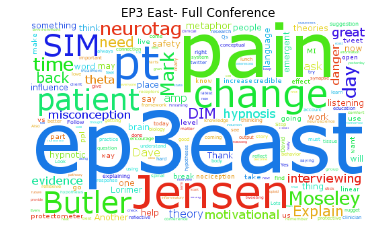

In [26]:
text = " ".join(df_east["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 East- Full Conference")
plt.savefig('ep3east.png', dpi=500)
plt.show()

Now to do the same things for days 1, 2 and 3 individually  
For these we'll just get the top 5 tweets of the day

### EP3 East Day 1 Retweets and Favorites
Day 1

In [27]:
east1_retweets = east1['retweet_count'].sum()
print east1_retweets
east1_favorites = east1['favorite_count'].sum()
print east1_favorites

648
878


### EP3 East Day 1 Top 5 Tweets

In [28]:
east1sorted_df = east1.sort_values(['important_tweets'], ascending = False)
east1sorted_df.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
1684,804732235035406336,noigroup,Moseley quoting Thacker. The job of the clinic...,25,49,2016-12-02 17:01:30,74,False
2021,804685603560427520,karenlitzyNYC,Thinking you have Pain sensors in your foot is...,26,40,2016-12-02 13:56:12,66,False
1746,804717682142617604,noigroup,Pain is TOTALLY dependent on context. @bodyinm...,25,32,2016-12-02 16:03:41,57,False
1542,804769235297771520,karenlitzyNYC,#ep3east I am just going to leave this here. @...,10,25,2016-12-02 19:28:32,35,False
1877,804701826385924096,karenlitzyNYC,Pain doesn't enter the brain it only comes out...,15,17,2016-12-02 15:00:40,32,False


### EP3 East Day 1 Word Cloud

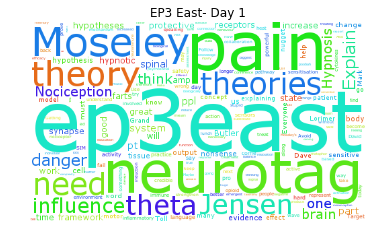

In [29]:
text = " ".join(east1["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 East- Day 1")
plt.savefig('ep3east_day1.png', dpi=500)
plt.show()

### EP3 East Day 2 Retweets and Favorites
Day 2

In [30]:
east2_retweets = east2['retweet_count'].sum()
print east2_retweets
east2_favorites = east2['favorite_count'].sum()
print east2_favorites

795
1097


### EP3 East Day 2 Top 5 Tweets

In [31]:
east2sorted_df = east2.sort_values(['important_tweets'], ascending = False)
east2sorted_df.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
1079,805077588922273793,noigroup,We DO NOT fix our patients. Our work is to cre...,63,63,2016-12-03 15:53:49,126,False
709,805150956585385986,noigroup,"""nociception is neither sufficient nor necessa...",32,41,2016-12-03 20:45:21,73,False
1078,805077711387553797,karenlitzyNYC,As the clinician we have to stop taking respon...,23,42,2016-12-03 15:54:18,65,False
697,805154419021115393,noigroup,"Moseley when the system is upregulated- ""you a...",24,25,2016-12-03 20:59:07,49,False
1043,805080588654936064,karenlitzyNYC,This a million times over! #ep3east ⬇️⬇️⬇️⬇️⬇️...,17,27,2016-12-03 16:05:44,44,False


### EP3 East Day 2 Word Cloud

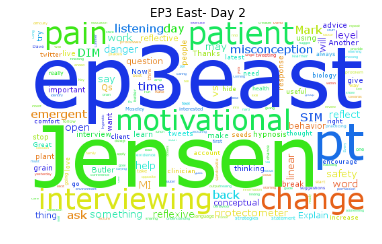

In [32]:
text = " ".join(east2["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 East- Day 2")
plt.savefig('ep3east_day2.png', dpi=500)
plt.show()

### Day 3 EP3 East Retweets and Favorites
Day 3

In [33]:
east3_retweets = east3['retweet_count'].sum()
print east3_retweets
east3_favorites = east3['favorite_count'].sum()
print east3_favorites

483
758


### Day 3 EP3 East Top 5 Tweets

In [34]:
east3sorted_df = east3.sort_values(['important_tweets'], ascending = False)
east3sorted_df.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
344,805430418166124544,traceyvincel,"""It's by bioplasticity that got you into pain ...",53,72,2016-12-04 15:15:50,125,False
115,805511401120919557,noigroup,A nugget for patients: the nerve only takes up...,15,36,2016-12-04 20:37:38,51,False
349,805429605175795712,traceyvincel,"Don't get hijacked by chronic pain ""We grow ne...",18,29,2016-12-04 15:12:36,47,False
577,805265625555664896,traceyvincel,"""Pain exist when credible evidence of danger i...",17,29,2016-12-04 04:21:00,46,False
162,805485905662377984,EricaMeloe,"""Change the language from pain is enemy to pai...",13,20,2016-12-04 18:56:19,33,False


### EP3 East Day 3 Word Cloud

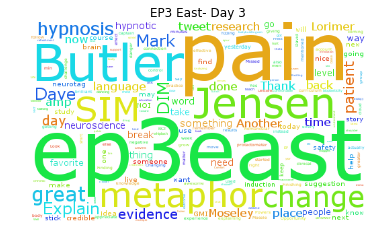

In [35]:
text = " ".join(east3["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 East- Day 3")
plt.savefig('ep3east_day3.png', dpi=500)
plt.show()

## EP3 West Analysis

All that looks good. Now let's do the same for the ep3west conference.  
Like before I'll grab the data from my database and put it into a dataframe.  
Next I'll change the format of the 'created_at column' then add the retweets+favorites column, then take out the retweets.  
On origional step that I will have to do is get rid of duplicates. I believe that I doubled up on collecting day 1 of the conference, so we'll have to make sure that we aren't counting duplicates. 

In [36]:
dataset_west = local_db['ep3west']

In [37]:
dataset_west.count()

3824

In [38]:
tweets_west = list(dataset_west.find())

In [39]:
df_west = process_results(tweets_west)

In [40]:
len(df_west)

3824

In [41]:
df_west = df_west.drop_duplicates()

In [42]:
len(df_west)

2384

In [43]:
df_west['created_at'] = pd.to_datetime(df_west['created_at'])

In [44]:
df_west['important_tweets'] = df_west['retweet_count'] + df_west['favorite_count']

In [45]:
df_west['retweeted'] = df_west['text'].str.startswith('RT')

### Total Tweets for EP3 West

In [46]:
df_west = df_west[df_west['retweeted'] == False]
len(df_west)

646

Wow, Very nearly the same number of origional tweets for EP3 East and EP3 West!  
Let's take a look at the top and bottom of the dataframe

In [47]:
df_west.head()

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
6,807411766342729728,IofManualNeuroS,"First day was great, can't wait for tomorrow. ...",0,0,2016-12-10 02:29:00,0,False
9,807392998048731136,PhysioKI,The shift in thinking #ep3west https://t.co/H3...,0,0,2016-12-10 01:14:26,0,False
24,807384664973283328,NOIgroupUSA,And that's a wrap for #ep3west day 1. Meet us ...,1,2,2016-12-10 00:41:19,3,False
30,807378646738419712,elliesomers_dpt,Getting @efeldmansurf nice and relaxed to incr...,1,1,2016-12-10 00:17:24,2,False
45,807374506368974848,SandyHiltonPT,"""The future that we imagine is the future that...",4,4,2016-12-10 00:00:57,8,False


In [48]:
df_west.tail()

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
3609,807278813100982272,SarahHaagPT,"If it's not biologically plausible, then you n...",8,7,2016-12-09 17:40:42,15,False
3688,807270749425651716,SanDiegoSummit,Follow NOI group on Twitter at #ep3West over t...,3,4,2016-12-09 17:08:39,7,False
3694,807270498228838400,noigroup,#EP3west theories like farts... they tend to d...,9,4,2016-12-09 17:07:39,13,False
3702,807270082392956929,SarahHaagPT,Our first group project.... #ep3west https://t...,4,5,2016-12-09 17:06:00,9,False
3814,807253591853387776,PainSciPod,Getting ready for #ep3west Look @scotmorrsn we...,6,15,2016-12-09 16:00:29,21,False


It all looks good. Now let's make the data set for the 3 days of the West conference

### EP3 West Day 1 Total Tweets
Day 1- 12/9/16

In [49]:
west1 = df_west[df_west['created_at'] < '2016-12-10']
len(west1)

290

### EP3 West Day 2 Total Tweets
Day 2- 12/10/16

In [50]:
west_df1 = df_west[df_west['created_at'] > '2016-12-10']
west2 = west_df1[west_df1['created_at'] < '2016-12-11']
len(west2)

233

### EP3 West Day 3 Total Tweets
Day 3- 12/11/16

In [51]:
west3 = df_west[df_west['created_at'] > '2016-12-11']
len(west3)

123

Now that we have our data sets for all of our dats, let's calculate the total number of retweets, the total number of favorites and the most important tweets. 
We'll start with the full conference data. 

### EP3 West Full Conference Retweets and Favorites

In [52]:
west_retweets = df_west['retweet_count'].sum()
print west_retweets
west_favorites = df_west['favorite_count'].sum()
print west_favorites

2703
2917


### EP3 West Top 10 Tweets

In [53]:
sorted_west = df_west.sort_values(['important_tweets'], ascending = False)
sorted_west.head(10)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
3254,807341467718909952,SarahHaagPT,Get people moving... motor output is anti-noci...,39,48,2016-12-09 21:49:40,87,False
1509,807341467718909952,SarahHaagPT,Get people moving... motor output is anti-noci...,37,46,2016-12-09 21:49:40,83,False
3505,807290129177972736,SandyHiltonPT,Lorimer: asking for adoption of this slide for...,22,28,2016-12-09 18:25:40,50,False
3554,807284647734308864,noigroup,Pain tolerance is different to pain threshold ...,22,26,2016-12-09 18:03:53,48,False
1809,807284647734308864,noigroup,Pain tolerance is different to pain threshold ...,22,25,2016-12-09 18:03:53,47,False
1760,807290129177972736,SandyHiltonPT,Lorimer: asking for adoption of this slide for...,20,27,2016-12-09 18:25:40,47,False
2903,807646148047450112,brettneilsondpt,#ep3west @noigroup Great message for the root ...,19,27,2016-12-10 18:00:21,46,False
1821,807283192231170052,SandyHiltonPT,Clinicians need to dig down through the layers...,17,24,2016-12-09 17:58:06,41,False
3543,807285478906949632,noigroup,Pain occurs when credible evidence of danger i...,23,18,2016-12-09 18:07:11,41,False
1798,807285478906949632,noigroup,Pain occurs when credible evidence of danger i...,23,17,2016-12-09 18:07:11,40,False


### EP3 West Full Conference Word Cloud

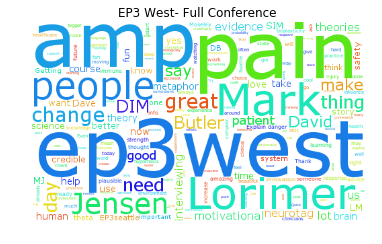

In [54]:
text = " ".join(df_west["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 West- Full Conference")
plt.savefig('ep3west.png', dpi=500)
plt.show()

On to the analysis by day for the West.  
Again we'll start with total retweets and favorites, then do the top 5 tweets and look at those for each day.

### EP3 West Day 1 Retweets and Favorites
Day 1- 12/9/16

In [55]:
west1_retweets = west1['retweet_count'].sum()
print west1_retweets
west1_favorites = west1['favorite_count'].sum()
print west1_favorites

1496
1602


### EP3 West Day 1 Top 5 Tweets

In [56]:
sorted_west1 = west1.sort_values(['important_tweets'], ascending = False)
sorted_west1.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
3254,807341467718909952,SarahHaagPT,Get people moving... motor output is anti-noci...,39,48,2016-12-09 21:49:40,87,False
1509,807341467718909952,SarahHaagPT,Get people moving... motor output is anti-noci...,37,46,2016-12-09 21:49:40,83,False
3505,807290129177972736,SandyHiltonPT,Lorimer: asking for adoption of this slide for...,22,28,2016-12-09 18:25:40,50,False
3554,807284647734308864,noigroup,Pain tolerance is different to pain threshold ...,22,26,2016-12-09 18:03:53,48,False
1809,807284647734308864,noigroup,Pain tolerance is different to pain threshold ...,22,25,2016-12-09 18:03:53,47,False


### EP3 West Day 1 Word Cloud

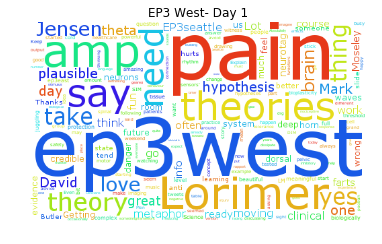

In [57]:
text = " ".join(west1["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 West- Day 1")
plt.savefig('ep3west_day1.png', dpi=500)
plt.show()

### EP3 West Day 2 Retweets and Favorites
Day 2- 12/10/16

In [58]:
west2_retweets = west2['retweet_count'].sum()
print west2_retweets
west2_favorites = west2['favorite_count'].sum()
print west2_favorites

760
849


### EP3 West Day 2 Top 5 Tweets

In [59]:
sorted_west2 = west2.sort_values(['important_tweets'], ascending = False)
sorted_west2.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
2903,807646148047450112,brettneilsondpt,#ep3west @noigroup Great message for the root ...,19,27,2016-12-10 18:00:21,46,False
1158,807646148047450112,brettneilsondpt,#ep3west @noigroup Great message for the root ...,16,21,2016-12-10 18:00:21,37,False
2802,807666724753403905,SandyHiltonPT,"""When people say things themselves, they belie...",14,19,2016-12-10 19:22:07,33,False
1057,807666724753403905,SandyHiltonPT,"""When people say things themselves, they belie...",12,15,2016-12-10 19:22:07,27,False
2659,807716513473970176,SandyHiltonPT,"We can't erase a neurotage that exists, but we...",7,14,2016-12-10 22:39:58,21,False


### EP3 West Day 2 Word Cloud

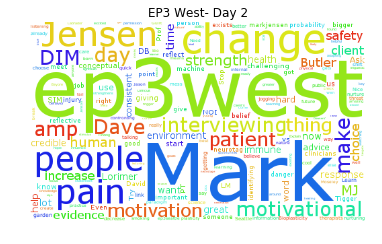

In [60]:
text = " ".join(west2["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 West- Day 2")
plt.savefig('ep3west_day2.png', dpi=500)
plt.show()

### EP3 West Day 3 Retweets and Favorites
Day 3- 12/11/16

In [61]:
west3_retweets = west3['retweet_count'].sum()
print west3_retweets
west3_favorites = west3['favorite_count'].sum()
print west3_favorites

447
466


### EP3 West Day 3 Top 5 Tweets

In [62]:
sorted_west3 = west3.sort_values(['important_tweets'], ascending = False)
sorted_west3.head(5)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
2444,808014677338820608,mattcurrier23,👌🏽 #ep3west https://t.co/Alzo89xrL1,15,15,2016-12-11 18:24:45,30,False
2240,808084706805694464,SarahHaagPT,'Dethreatening is nothing more than telling th...,12,14,2016-12-11 23:03:02,26,False
2563,807746845015306240,SandyHiltonPT,"""The immune system, the system that knows who ...",9,12,2016-12-11 00:40:29,21,False
2450,808005649296551936,SarahHaagPT,Case studies- great to hear what's gone well. ...,6,14,2016-12-11 17:48:53,20,False
2496,807989177375522816,SandyHiltonPT,Teamwork is needed to help people with pain. R...,10,8,2016-12-11 16:43:26,18,False


### EP3 West Day 3 Word Cloud

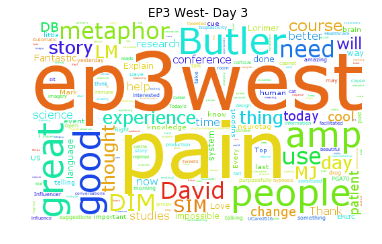

In [63]:
text = " ".join(west3["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'ep3east'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("EP3 West- Day 3")
plt.savefig('ep3west_day3.png', dpi=500)
plt.show()

Great, now we've got all of our data, but it's tough to look at. Let's make some bar graphs and compare West to East in each category.

## Charts to Make Comparisons Easier

First let's look at total tweets for each conference

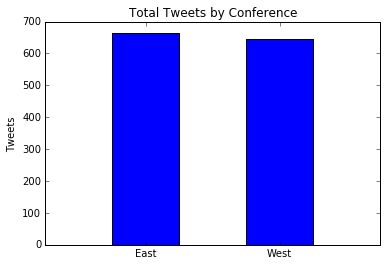

In [64]:
east = len(df_east)
west = len(df_west)
labels = ["East", "West"]
data = [east, west]

xlocations = np.array(range(len(data)))+0.5
width = 0.5
plt.bar(xlocations, data, width=width)
plt.xticks(xlocations+width/2, labels)
plt.xlim(0, xlocations[-1]+width*2)
plt.title("Total Tweets by Conference")
plt.ylabel("Tweets")
plt.savefig("total tweets by conference.png")
plt.show()

Now Let's Look at Retweets by Conference

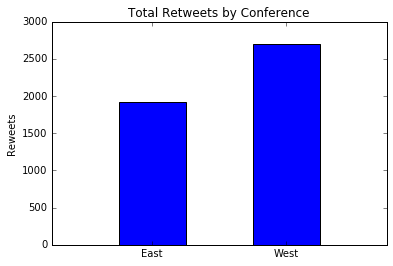

In [65]:
east = east_retweets
west = west_retweets
labels = ["East", "West"]
data = [east, west]

xlocations = np.array(range(len(data)))+0.5
width = 0.5
plt.bar(xlocations, data, width=width)
plt.xticks(xlocations+width/2, labels)
plt.xlim(0, xlocations[-1]+width*2)
plt.title("Total Retweets by Conference")
plt.ylabel("Reweets")
plt.savefig("Total Retweets by Conference.png")

plt.show()

Next we'll look at favorites by conference

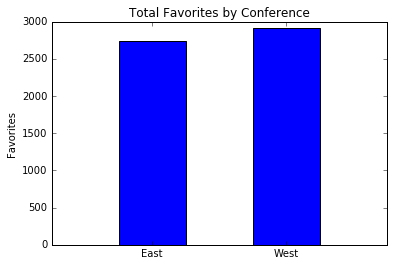

In [66]:
east = east_favorites
west = west_favorites
labels = ["East", "West"]
data = [east, west]

xlocations = np.array(range(len(data)))+0.5
width = 0.5
plt.bar(xlocations, data, width=width)
plt.xticks(xlocations+width/2, labels)
plt.xlim(0, xlocations[-1]+width*2)
plt.title("Total Favorites by Conference")
plt.ylabel("Favorites")
plt.savefig("Total Favorites by Conference")

plt.show()

Now Let's look at the total tweets, retweets and favorites for each day within each conference
First we'll start with total tweets

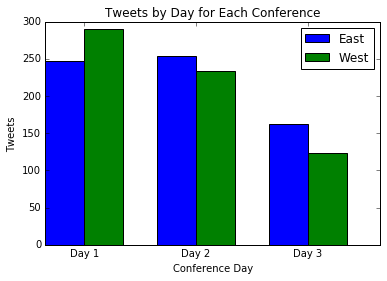

In [67]:
n_groups = 3
east_tweets = (len(east1), len(east2), len(east3))
west_tweets = (len(west1), len(west2), len(west3))

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, east_tweets, bar_width, color='b', label='East')

rects2 = plt.bar(index + bar_width, west_tweets, bar_width, color='g', label='West')

plt.xlabel('Conference Day')
plt.ylabel('Tweets')
plt.xticks(index + bar_width, ('Day 1', 'Day 2', 'Day 3'))
plt.title("Tweets by Day for Each Conference")
plt.legend()
plt.savefig('tweets by day.png')
plt.show()

Next we'll look at retweets by day

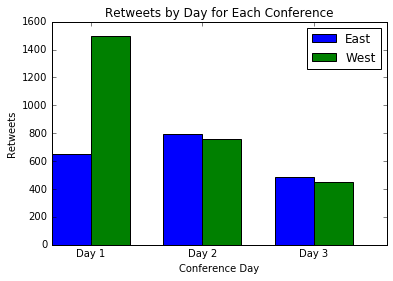

In [68]:
n_groups = 3
east_tweets = (east1_retweets, east2_retweets, east3_retweets)
west_tweets = (west1_retweets, west2_retweets, west3_retweets)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, east_tweets, bar_width, color='b', label='East')

rects2 = plt.bar(index + bar_width, west_tweets, bar_width, color='g', label='West')

plt.xlabel('Conference Day')
plt.ylabel('Retweets')
plt.xticks(index + bar_width, ('Day 1', 'Day 2', 'Day 3'))
plt.title("Retweets by Day for Each Conference")
plt.legend()
plt.savefig('retweets by day.png')
plt.show()

Finally we'll look at favorties by day for each conference

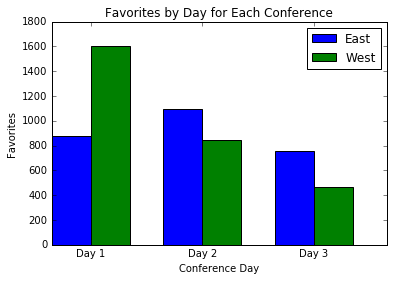

In [69]:
n_groups = 3
east_tweets = (east1_favorites, east2_favorites, east3_favorites)
west_tweets = (west1_favorites, west2_favorites, west3_favorites)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, east_tweets, bar_width, color='b', label='East')

rects2 = plt.bar(index + bar_width, west_tweets, bar_width, color='g', label='West')

plt.xlabel('Conference Day')
plt.ylabel('Favorites')
plt.xticks(index + bar_width, ('Day 1', 'Day 2', 'Day 3'))
plt.title("Favorites by Day for Each Conference")
plt.legend()
plt.savefig('favorites by day.png')
plt.show()

That's it!  
Hopefully you found this interesting.  
If you did, let me know at [@CodyWeisbach](http://twitter.com/codyweisbach) on Twitter.  
If people are interested I'll do a similar analysis for each session of the conference. 